# TEST 1:

In [1]:
# Add the 'src' as root folder, to find other modules in the project
import sys
sys.path.append("../")

In [2]:
# import other internal modules and functions
from simulator.swing_equation import simulator

# import other external modules and functions
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.utils import BoxUniform, posterior_nn
import numpy as np
import torch


c:\Users\basti\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
num_simulations = [100, 1000, 10000, 25000, 50000, 100000]

In [4]:
# Define the prior distribution for the parameters
prior = BoxUniform(
    low=torch.tensor([0.1, 1.0, 0.1, 40.0, 0.1]),
    high=torch.tensor([10.0, 100.0, 10.0, 70.0, 10.0])
)

# Define the true parameters for training and evaluation
true_parameters = torch.tensor([4.0, 40.0, 3.0, 60.0, 7.0])

# Simulate the observation
observation = simulator(true_parameters)

# Wrap the simulator function for compatibility with SBI
simulator, prior = prepare_for_sbi(simulator, prior)

posteriors = []

for num in num_simulations:

    # Instantiate the neural density estimator
    neural_posterior = posterior_nn(
        model="maf", hidden_features=10, num_transforms=2
    )

    # Set up the inference procedure with the SNPE-C procedure
    inference = SNPE(prior=prior, density_estimator=neural_posterior)

    # Run the inference procedure to generate samples and corresponding simulated data points
    theta, x = simulate_for_sbi(simulator, prior, num_simulations=num)

    # train the neural density estimator
    density_estimator = inference.append_simulations(theta, x).train()

    # build the posterior for the given parameters
    posterior = inference.build_posterior(density_estimator)
    posterior.set_default_x(observation)

    posteriors.append(posterior)

Running 100 simulations.: 100%|██████████| 100/100 [00:01<00:00, 81.65it/s]


 Neural network successfully converged after 1476 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:11<00:00, 88.89it/s]


 Neural network successfully converged after 407 epochs.

Running 10000 simulations.: 100%|██████████| 10000/10000 [01:47<00:00, 92.69it/s]


 Neural network successfully converged after 184 epochs.

Running 25000 simulations.: 100%|██████████| 25000/25000 [04:29<00:00, 92.80it/s]


 Neural network successfully converged after 306 epochs.

Running 50000 simulations.: 100%|██████████| 50000/50000 [09:02<00:00, 92.17it/s]


 Neural network successfully converged after 124 epochs.

Running 100000 simulations.: 100%|██████████| 100000/100000 [18:24<00:00, 90.57it/s]


 Neural network successfully converged after 115 epochs.

Drawing 100 posterior samples: 159it [00:00, 11959.01it/s]            


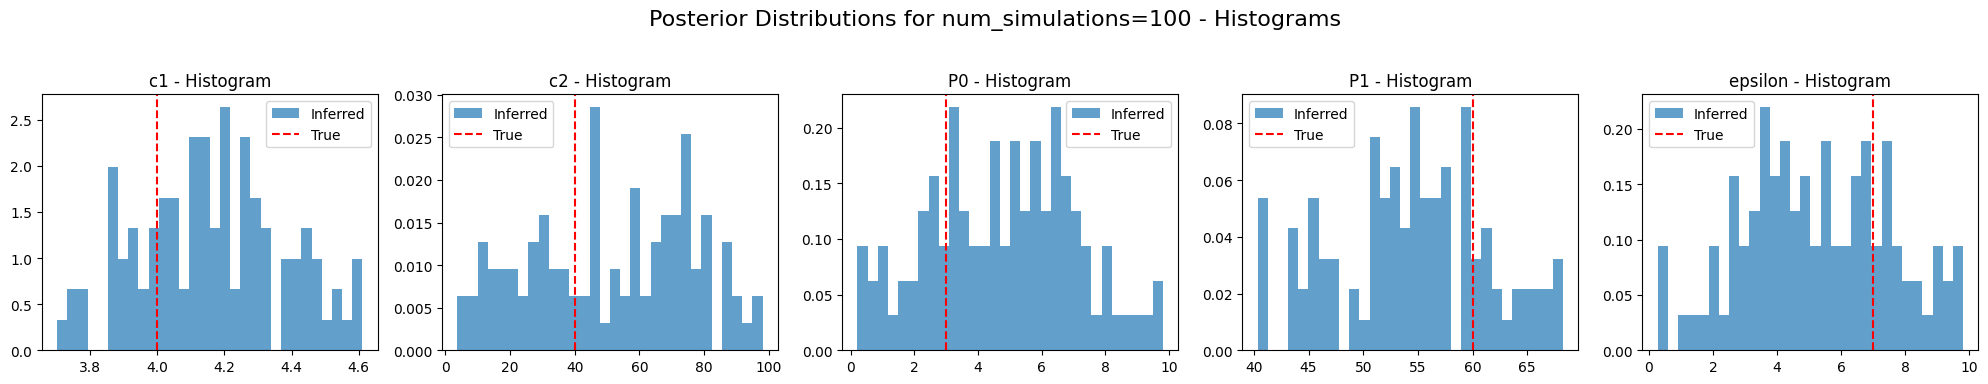

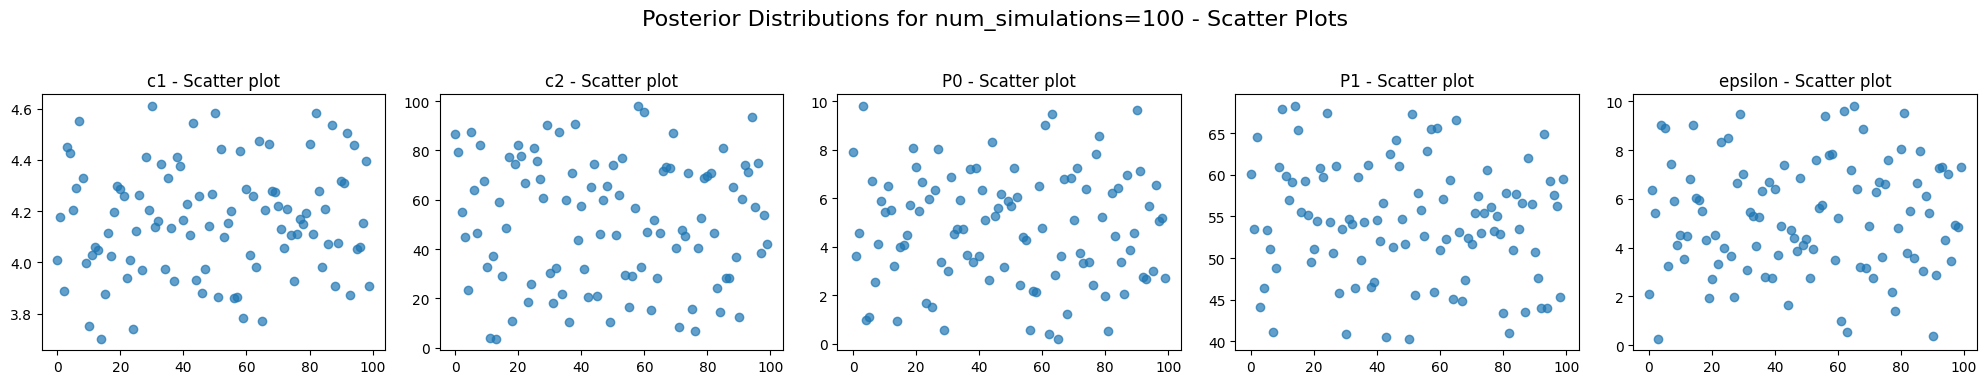

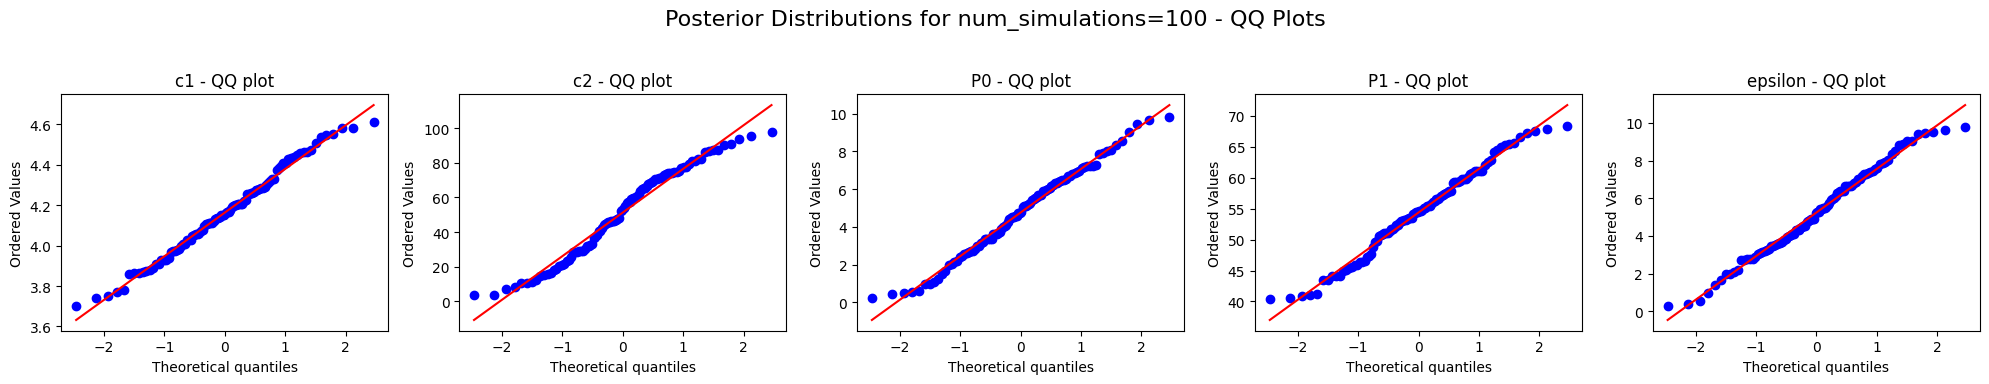

Drawing 1000 posterior samples: 1080it [00:00, 181317.23it/s]           


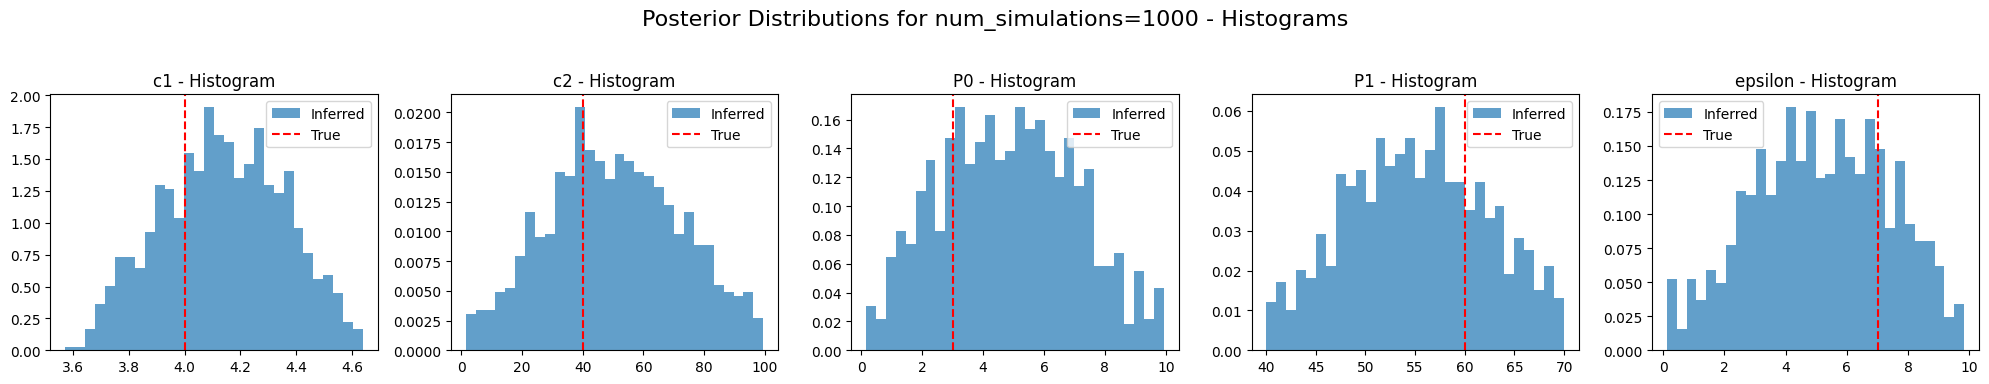

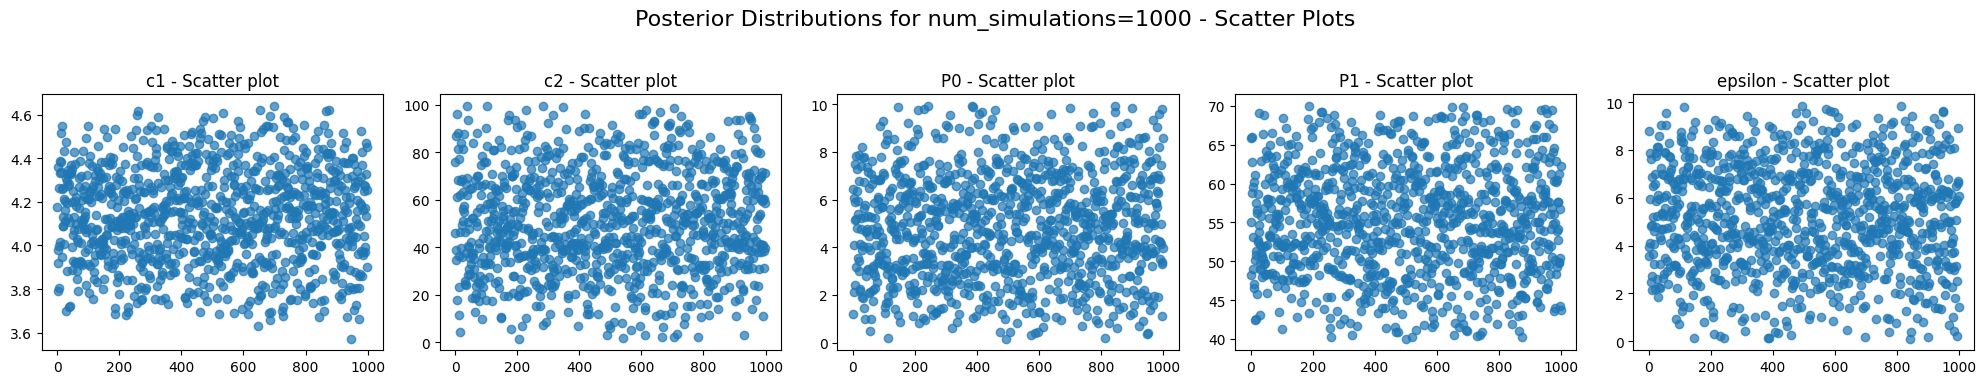

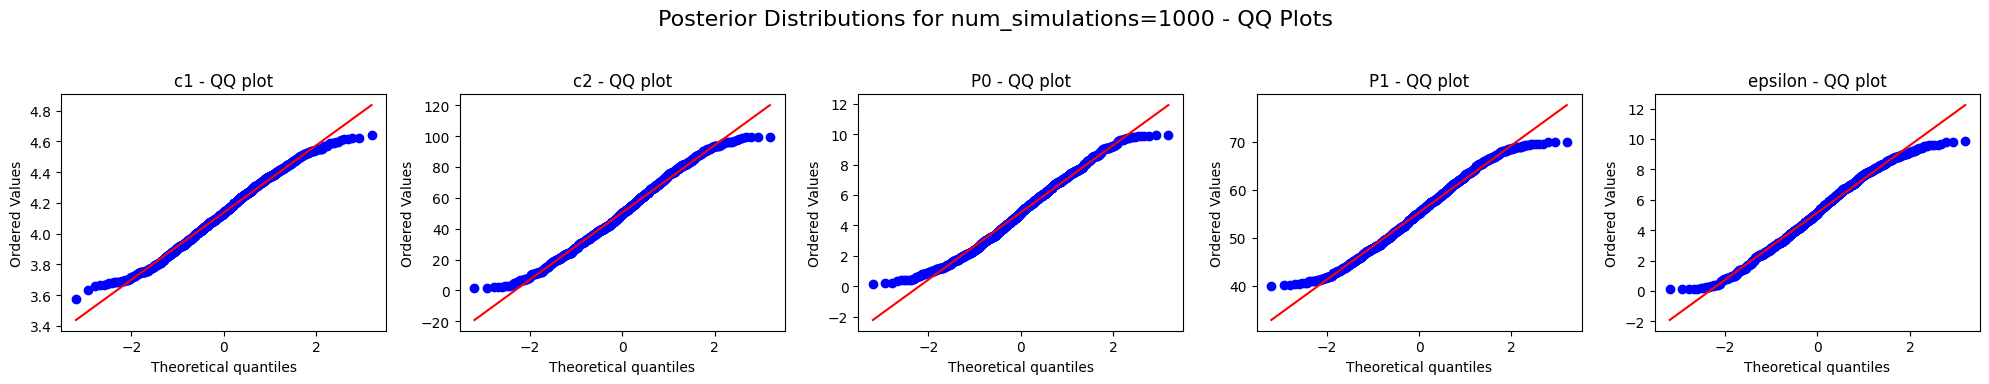

Drawing 10000 posterior samples: 10983it [00:00, 136372.77it/s]           


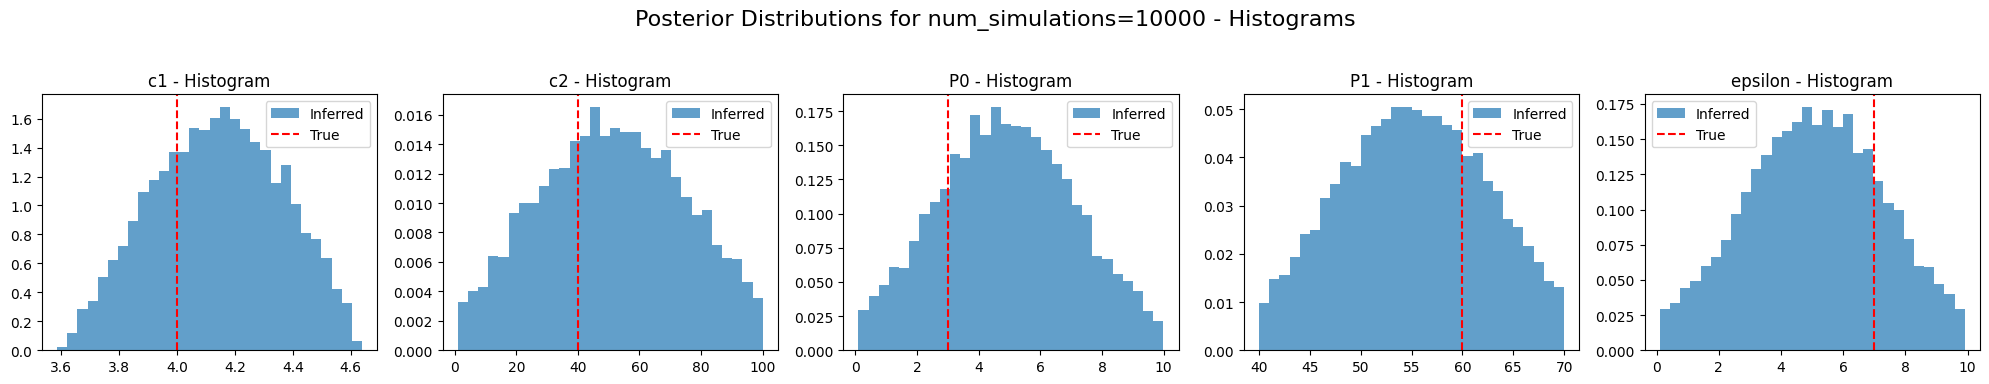

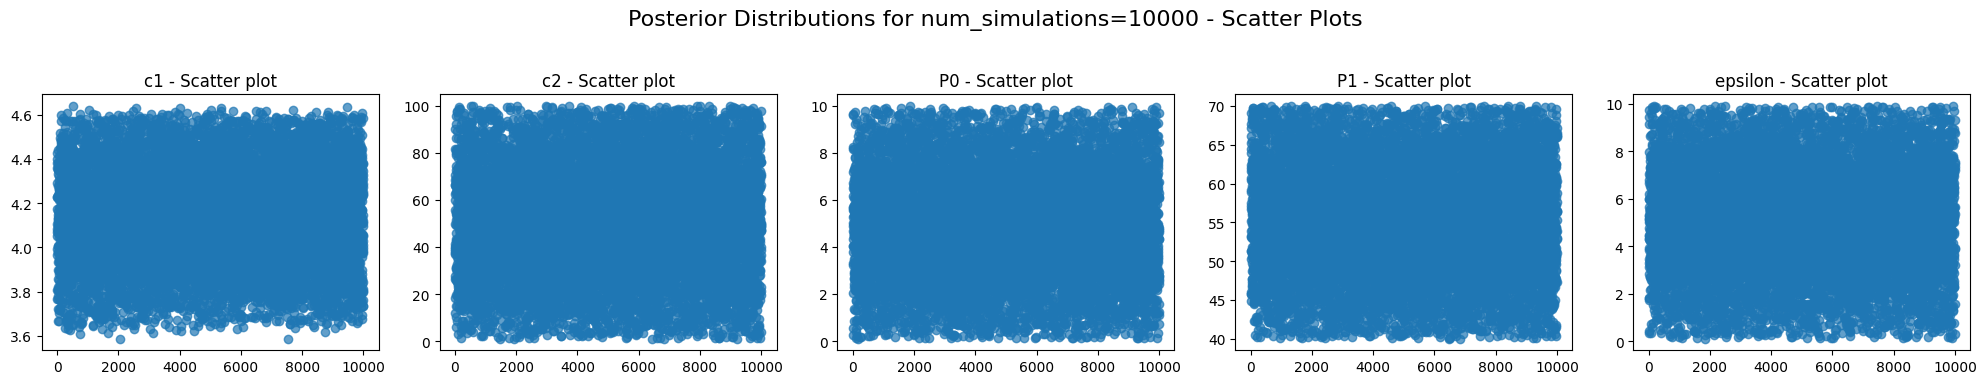

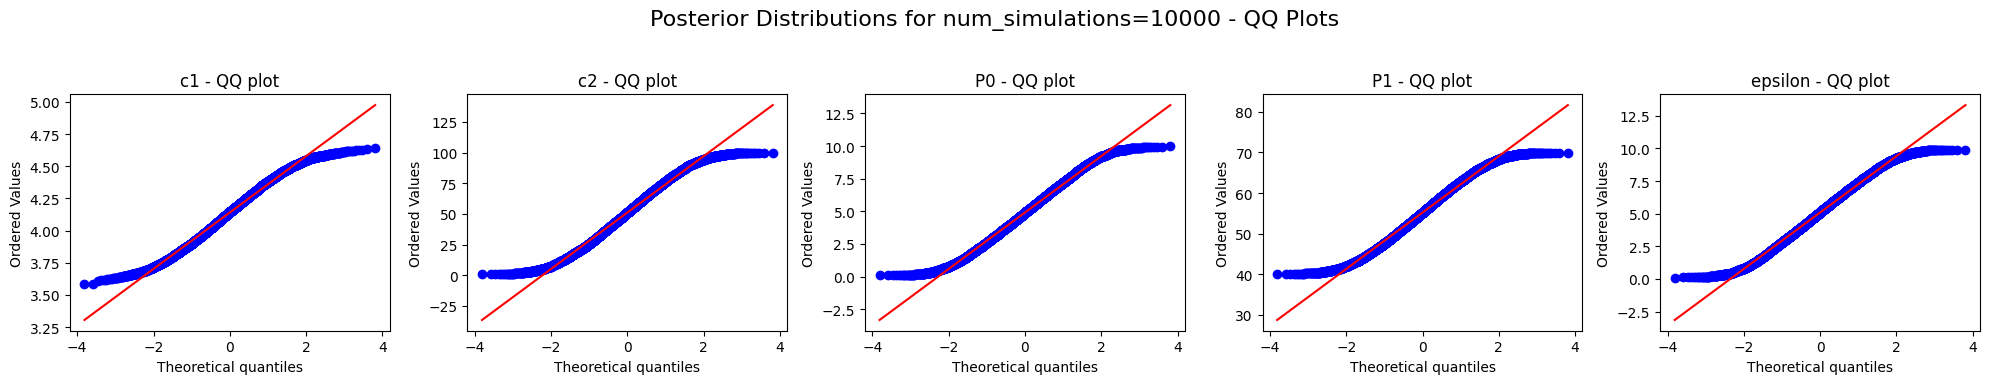

Drawing 25000 posterior samples: 25486it [00:00, 215807.71it/s]                           


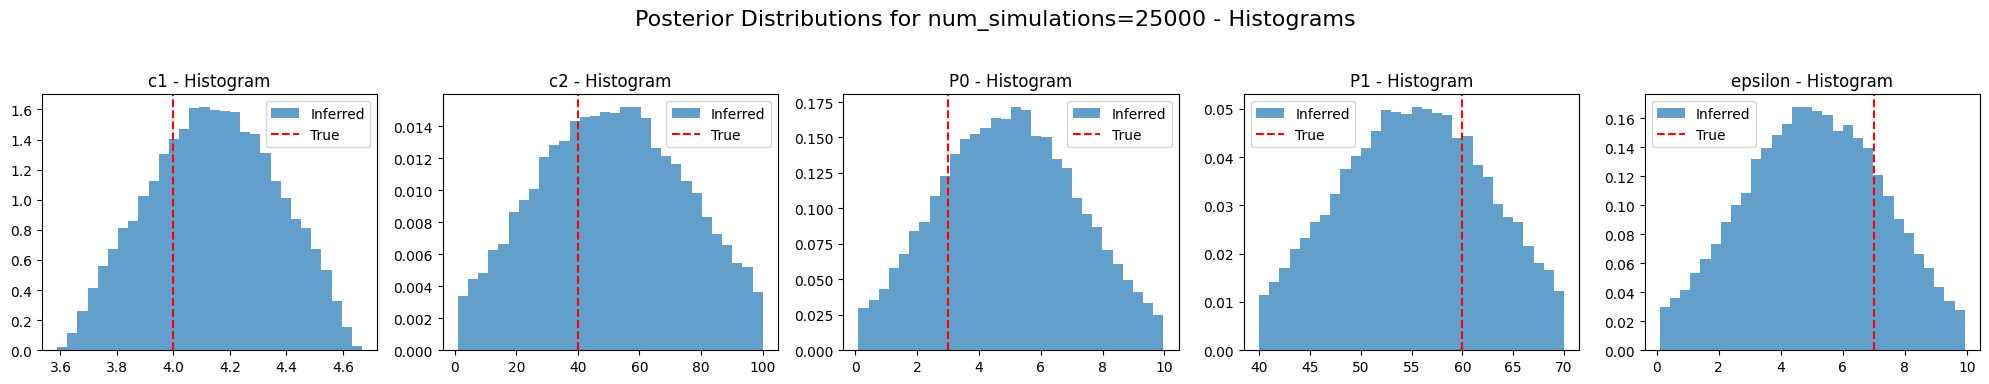

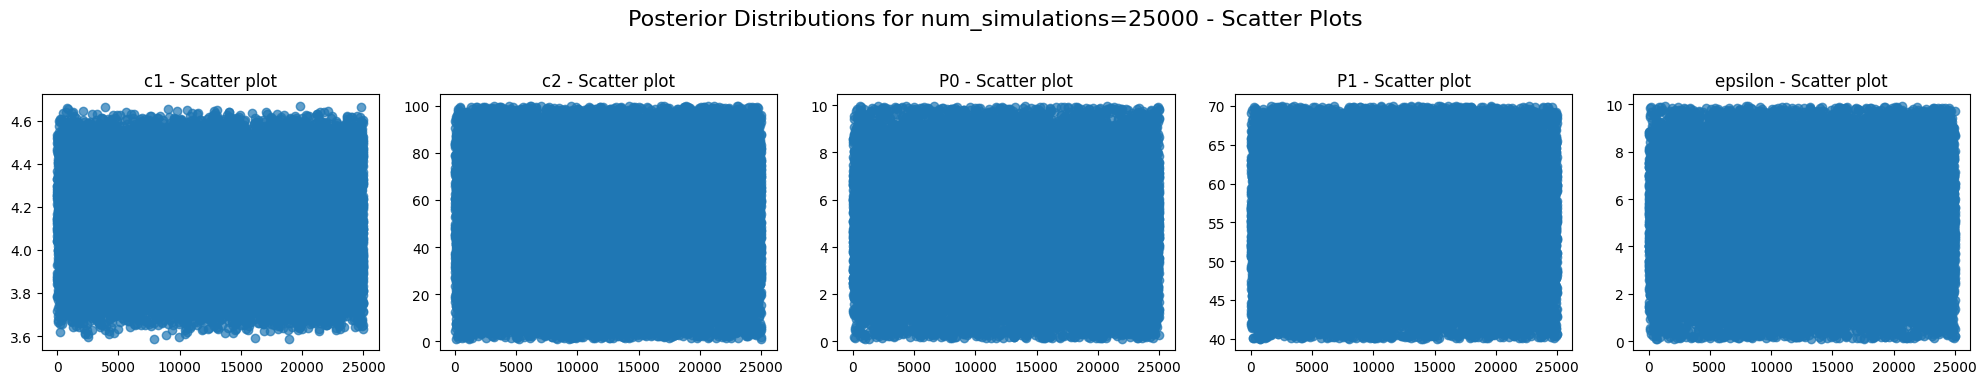

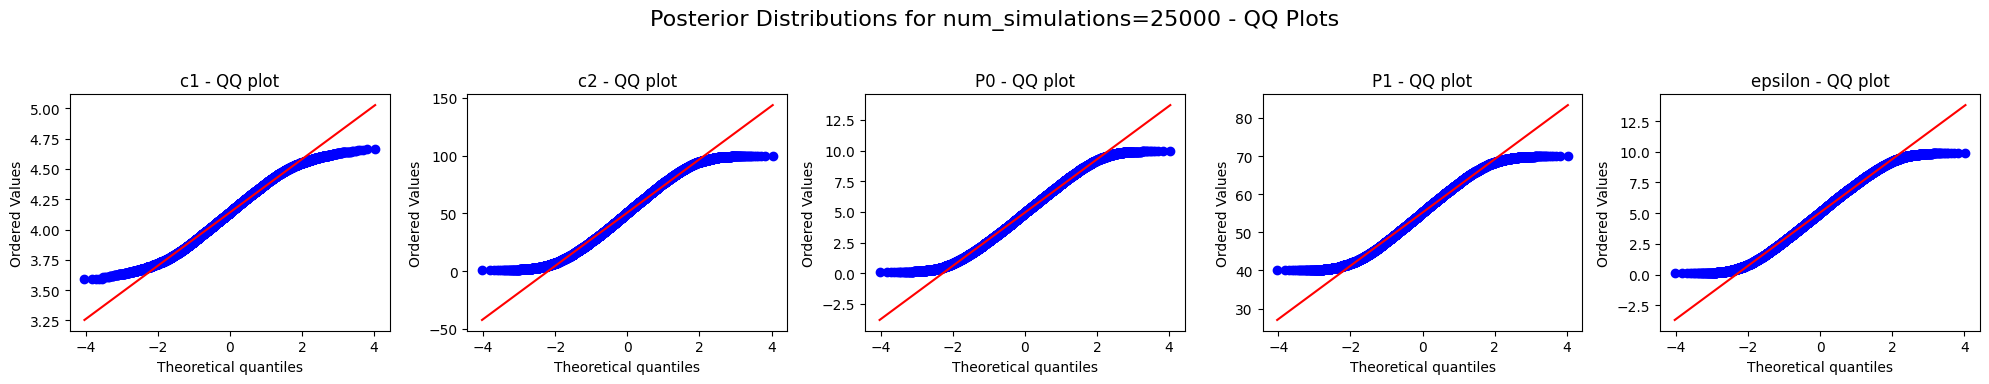

Drawing 50000 posterior samples: 50945it [00:00, 262831.13it/s]                           


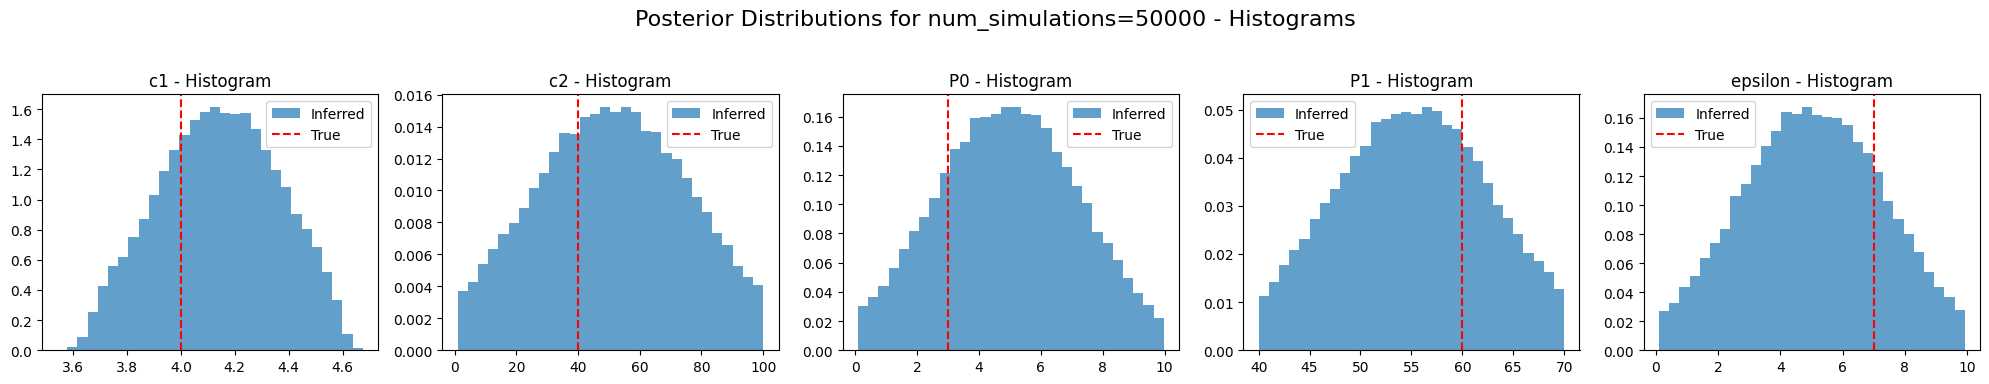

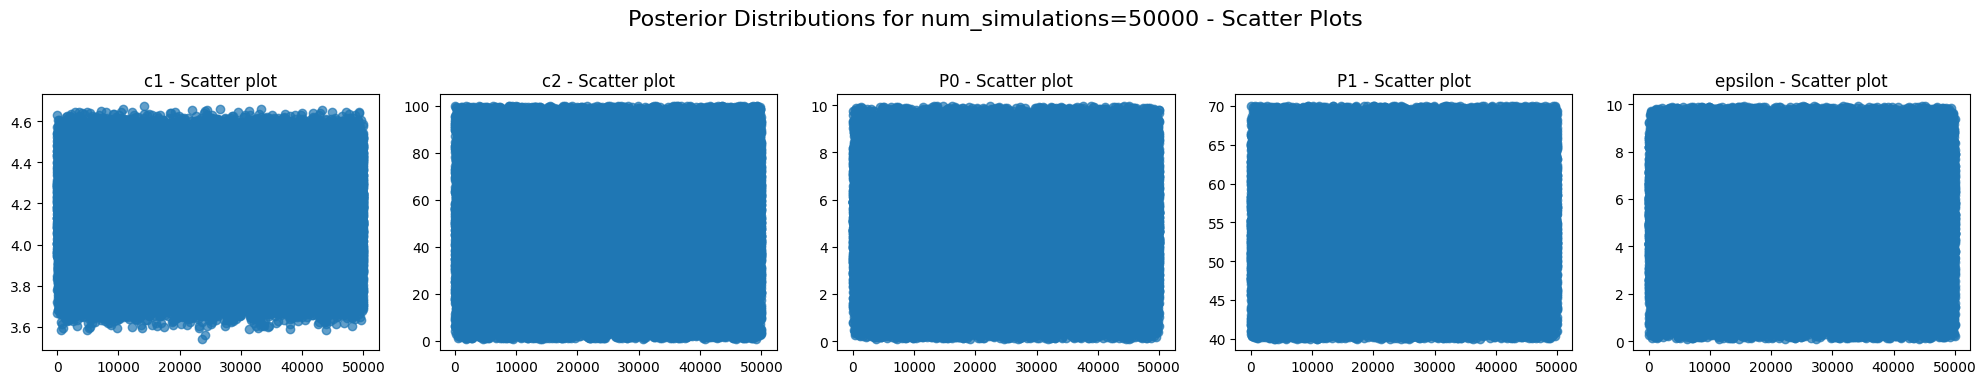

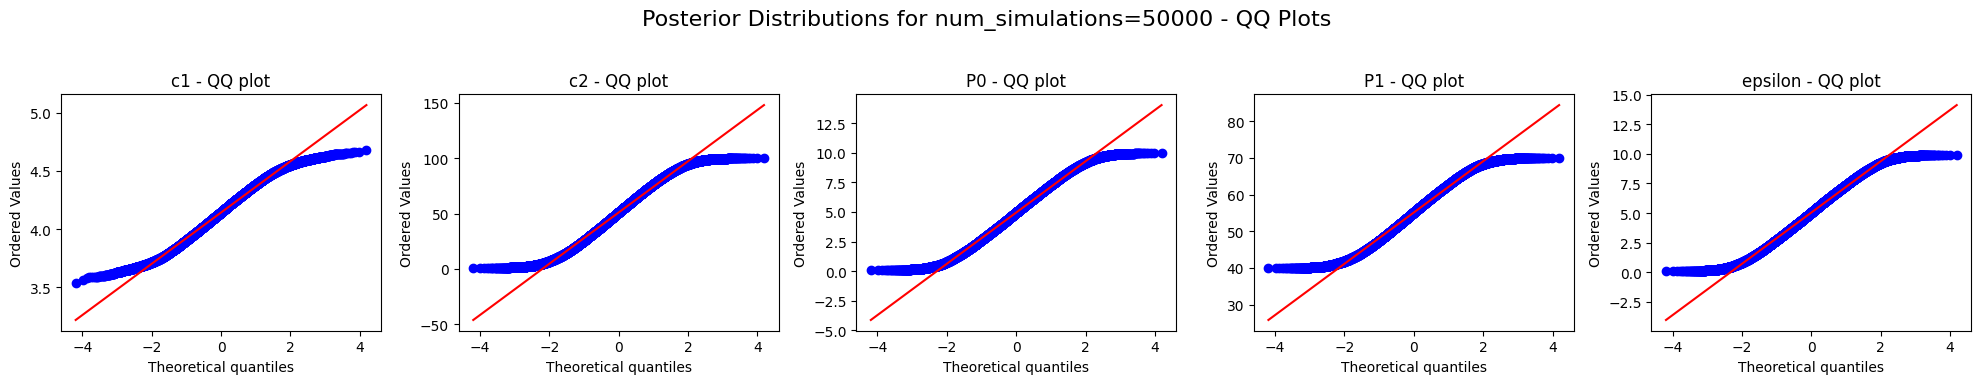

Drawing 100000 posterior samples: 102117it [00:00, 283559.45it/s]                           


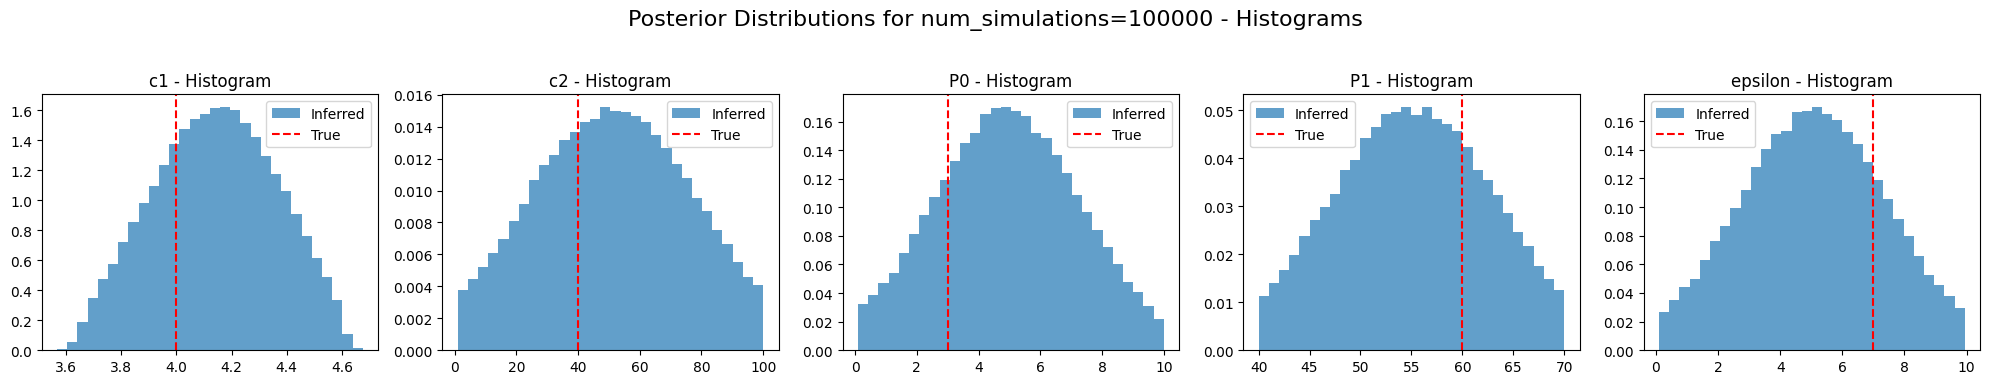

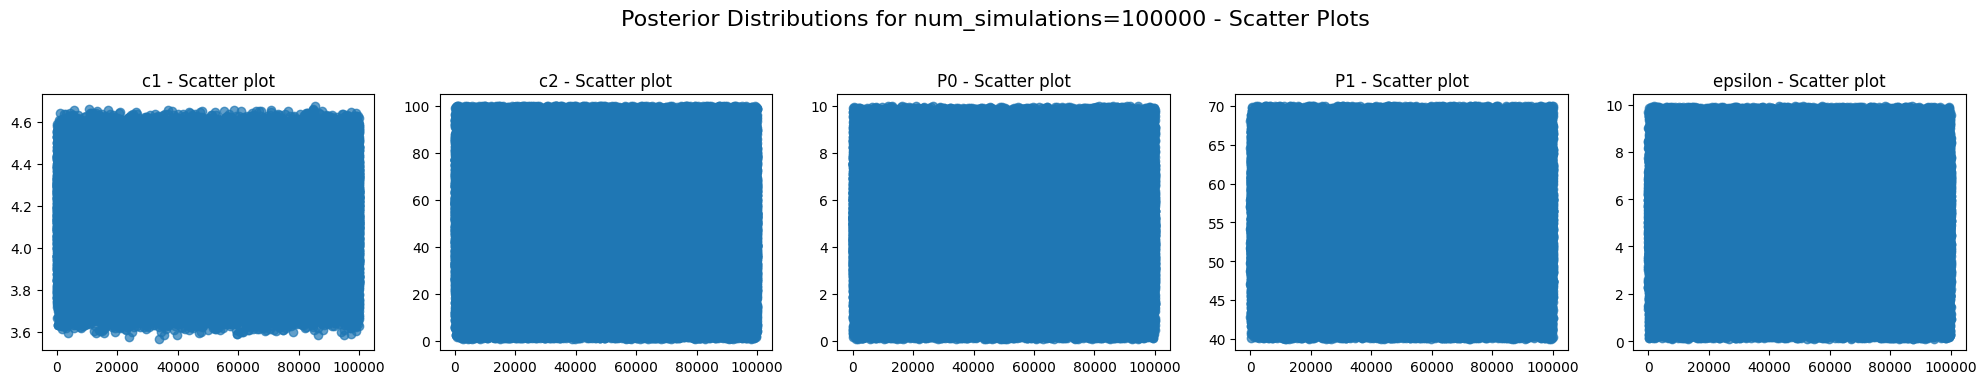

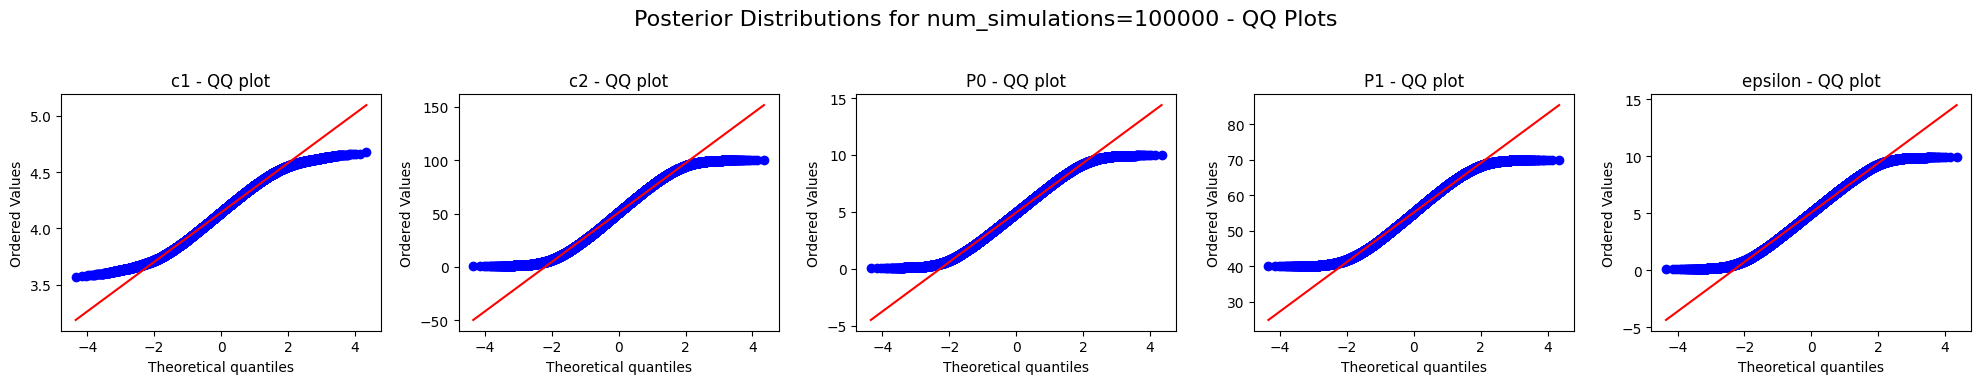

In [21]:
from matplotlib import pyplot as plt
import scipy.stats as stats

# Plot settings
param_names = ['c1', 'c2', 'P0', 'P1', 'epsilon']

for i, num_simulations in enumerate(num_simulations):
    
    # Extract posterior distributions for current num_simulations
    posterior_samples = posterior.sample((num_simulations,))

    # Create separate figures for each type of plot
    fig1, axes1 = plt.subplots(1, len(param_names), figsize=(20, 4))
    fig2, axes2 = plt.subplots(1, len(param_names), figsize=(20, 4))
    fig3, axes3 = plt.subplots(1, len(param_names), figsize=(20, 4))

    # Plot each parameter for current num_simulations
    for j in range(len(param_names)):
        parameter_samples = posterior_samples[:, j]
        
        # Histogram
        axes1[j].hist(parameter_samples, bins=30, density=True, alpha=0.7, label='Inferred')
        axes1[j].axvline(x=true_parameters[j], color='red', linestyle='--', label='True')
        axes1[j].set_title(param_names[j] + ' - Histogram')
        axes1[j].legend()
        
        # Scatter plot
        axes2[j].scatter(range(len(parameter_samples)), parameter_samples, alpha=0.7)
        axes2[j].set_title(param_names[j] + ' - Scatter plot')
        
        # QQ plot
        stats.probplot(parameter_samples, dist="norm", plot=axes3[j])
        axes3[j].set_title(param_names[j] + ' - QQ plot')

    # Set titles for the figures
    fig1.suptitle(f'Posterior Distributions for num_simulations={num_simulations} - Histograms', fontsize=16)
    fig2.suptitle(f'Posterior Distributions for num_simulations={num_simulations} - Scatter Plots', fontsize=16)
    fig3.suptitle(f'Posterior Distributions for num_simulations={num_simulations} - QQ Plots', fontsize=16)

    # Adjust layout and show the figures
    fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig3.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [32]:
import pandas as pd
import numpy as np
from scipy.stats import mode, kurtosis, skew

# Initialize lists to store the results
medians = []
stds = []
kurtoses = []
skews = []

# Calculate the statistics for each posterior
for i, posterior in enumerate(posteriors):
    samples = posterior.sample((10000,), show_progress_bars=False)
    samples_np = samples.numpy()
    median = np.median(samples_np, axis=0)
    std = np.std(samples_np, axis=0)
    kurt = kurtosis(samples_np, axis=0)
    skewness = skew(samples_np, axis=0)
    
    medians.append([num_simulations[i]] + list(median))
    stds.append([num_simulations[i]] + list(std)) 
    kurtoses.append([num_simulations[i]] + list(kurt))
    skews.append([num_simulations[i]] + list(skewness))

# Create a DataFrame for each statistic
df_medians = pd.DataFrame(medians, columns=['num_simulations'] + param_names)
df_medians.set_index('num_simulations', inplace=True)

df_stds = pd.DataFrame(stds, columns=['num_simulations'] + param_names)
df_stds.set_index('num_simulations', inplace=True)

df_kurtoses = pd.DataFrame(kurtoses, columns=['num_simulations'] + param_names)
df_kurtoses.set_index('num_simulations', inplace=True)

df_skews = pd.DataFrame(skews, columns=['num_simulations'] + param_names)
df_skews.set_index('num_simulations', inplace=True)

# Print the tables
print("Medians:")
print(df_medians)
print("\nStandard Deviations:")
print(df_stds)
print("\nKurtoses:")
print(df_kurtoses)
print("\nSkews:")
print(df_skews)


Medians:
                       c1         c2        P0         P1   epsilon
num_simulations                                                    
100              4.205345  48.012184  4.515553  54.552402  5.611845
1000             5.133028  50.387924  4.937796  55.597309  5.103108
10000            5.035236  50.533806  4.753775  49.794960  5.166194
25000            4.976405  50.075279  4.903754  53.288544  5.062655
50000            4.183046  50.226772  5.044789  55.015236  4.958165
100000           4.142760  50.646225  4.926079  55.277901  5.073340

Standard Deviations:
                       c1         c2        P0         P1   epsilon
num_simulations                                                    
100              0.500117  23.016512  1.933008   6.638010  1.923913
1000             2.331326  23.091856  1.902056   6.949937  1.882826
10000            1.931744  23.179752  2.000787  10.731050  2.018629
25000            1.225575  23.411757  2.161558   8.017275  2.153912
50000            